<a href="https://colab.research.google.com/github/Ebad-urRehman/MAHED_2025_subtask1_hate_and_hope/blob/main/notebooks/hope_and_hate_managed_with_class_imbalance_handling_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training with oversampling

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Epoch 1 | Loss: 320.1336 | Accuracy: 0.6575
Epoch 2 | Loss: 224.2374 | Accuracy: 0.7816
Epoch 3 | Loss: 154.5599 | Accuracy: 0.8642
Epoch 4 | Loss: 104.7220 | Accuracy: 0.9177
Epoch 5 | Loss: 73.0367 | Accuracy: 0.9421
Epoch 6 | Loss: 55.0818 | Accuracy: 0.9595
Epoch 7 | Loss: 45.8190 | Accuracy: 0.9660
Epoch 8 | Loss: 34.8242 | Accuracy: 0.9745

📊 Classification Report:
                precision    recall  f1-score   support

          hate      0.989     0.992     0.990      2254
          hope      0.979     0.994     0.986      2265
not_applicable      0.991     0.975     0.983      2371

      accuracy                          0.987      6890
     macro avg      0.986     0.987     0.987      6890
  weighted avg      0.987     0.987     0.986      6890

🔁 Macro F1: 0.9865513120383834


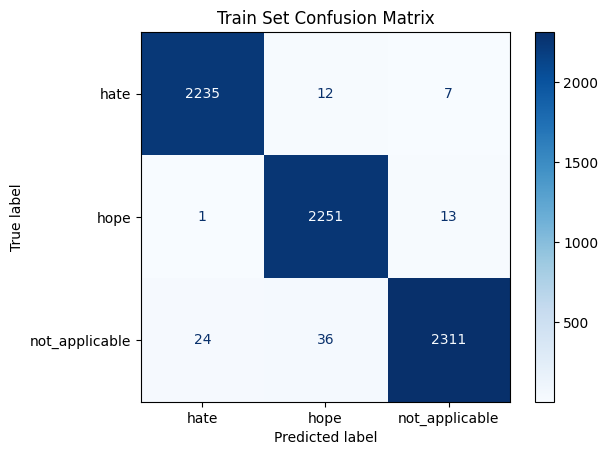

In [ ]:
# WITH OVERSAMPLING
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import json, re, string, nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/train.csv")
texts_raw = df["text"].astype(str).tolist()
labels_raw = df["label"].tolist()

# Encode labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_raw)  # 0,1,2 for hope/hate/not_applicable

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

cleaned_texts = [clean_text(t) for t in texts_raw]

#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)

#  Oversampling
# Compute sample weights
class_sample_counts = np.bincount(labels)
weights = 1. / class_sample_counts
sample_weights = [weights[label] for label in labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(dataset, batch_size=16, sampler=sampler)

#  Model
class BertClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier(num_classes=len(label_encoder.classes_)).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

#  Training Loop
model.train()
for epoch in range(8):
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels_batch).sum().item()
        total += labels_batch.size(0)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {correct/total:.4f}")

#  Evaluate on Train
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))

#  Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Train Set Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/colab_data/new models/bert_base_new_with_oversampling.pt')


📊 Test Set Classification Report:
                precision    recall  f1-score   support

          hope      0.985     0.988     0.987       260
          hate      0.974     0.987     0.980       379
not_applicable      0.990     0.982     0.986       739

      accuracy                          0.985      1378
     macro avg      0.983     0.986     0.984      1378
  weighted avg      0.985     0.985     0.985      1378

🔁 Test Macro F1: 0.9844393676865729
🔁 Macro Accuracy: 0.9847605224963716
🔁 Macro Precision: 0.9830276224912403
🔁 Macro Recall: 0.985892528892054


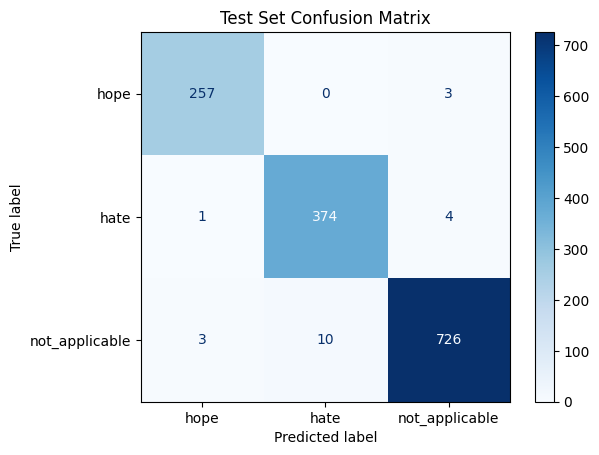

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score


# ✅ Split only for evaluation
train_texts, test_texts, train_labels, test_labels = train_test_split(
    cleaned_texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Tokenize only test set (train_loader stays same as before)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)
test_dataset = ArabicDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#  Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

print("\n📊 Test Set Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Test Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Test Set Confusion Matrix")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Evaluation on validation.csv:
                precision    recall  f1-score   support

          hope      0.029     0.014     0.019       509
          hate      0.009     0.019     0.012       158
not_applicable      0.751     0.837     0.792       809

      accuracy                          0.465      1476
     macro avg      0.263     0.290     0.274      1476
  weighted avg      0.423     0.465     0.442      1476

🔁 Macro F1: 0.27422487856088446
🔁 Macro Accuracy: 0.4654471544715447
🔁 Macro Precision: 0.26310732541183557
🔁 Macro Recall: 0.2898584656911307


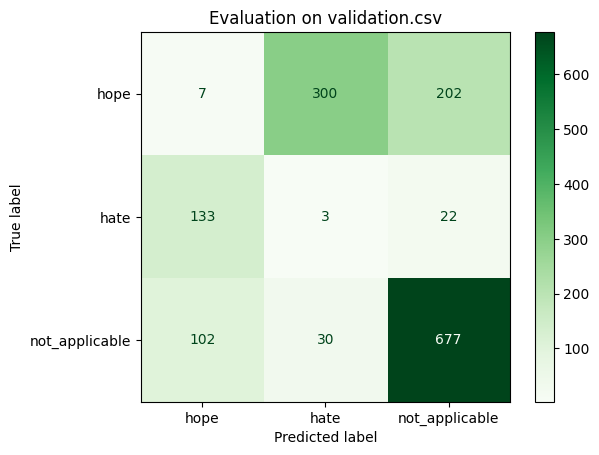

In [ ]:
## This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["predicted_label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))


#  Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#  Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new_with_oversampling.pt", map_location=device), strict=False)
model.eval()

#  Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Evaluation on validation.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on validation.csv")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Evaluation on test.csv:
                precision    recall  f1-score   support

          hope      0.039     0.024     0.029       422
          hate      0.024     0.028     0.026       287
not_applicable      0.632     0.730     0.678       768

      accuracy                          0.392      1477
     macro avg      0.232     0.261     0.244      1477
  weighted avg      0.345     0.392     0.366      1477

🔁 Macro F1: 0.24440184206867058
🔁 Macro Accuracy: 0.3920108327691266
🔁 Macro Precision: 0.2317750240274874
🔁 Macro Recall: 0.2606799989747951


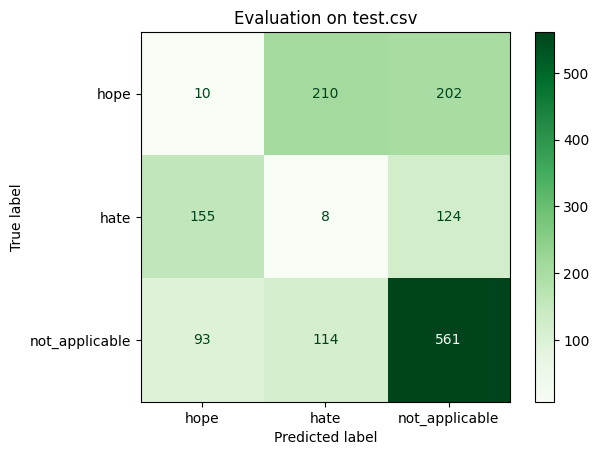

In [ ]:
## This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))


#  Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#  Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new_with_oversampling.pt", map_location=device), strict=False)
model.eval()

#  Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Evaluation on test.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on test.csv")
plt.show()


# UNDER SAMPLED DATA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1 | Loss: 208.4426 | Accuracy: 0.5885
Epoch 2 | Loss: 161.5249 | Accuracy: 0.7120
Epoch 3 | Loss: 112.4525 | Accuracy: 0.8119
Epoch 4 | Loss: 72.6768 | Accuracy: 0.8873
Epoch 5 | Loss: 39.7121 | Accuracy: 0.9408
Epoch 6 | Loss: 22.4606 | Accuracy: 0.9703
Epoch 7 | Loss: 20.8949 | Accuracy: 0.9718
Epoch 8 | Loss: 13.9723 | Accuracy: 0.9839

📊 Classification Report:
                precision    recall  f1-score   support

          hate      0.992     0.995     0.993      1301
          hope      0.996     0.994     0.995      1301
not_applicable      0.992     0.990     0.991      1301

      accuracy                          0.993      3903
     macro avg      0.993     0.993     0.993      3903
  weighted avg      0.993     0.993     0.993      3903

🔁 Macro F1: 0.9930821338990986


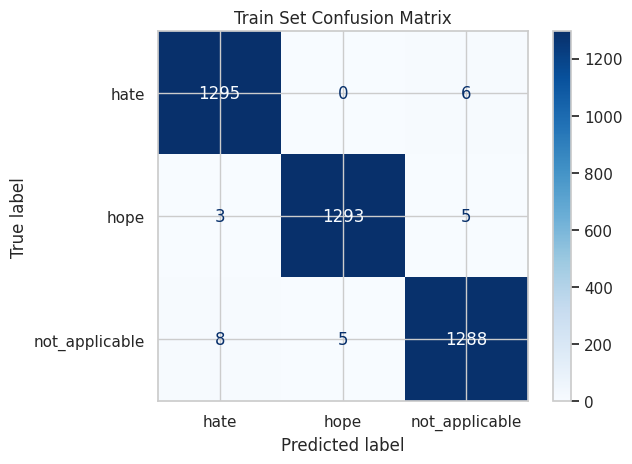

In [ ]:
# WITH Undersampling
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import json, re, string, nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/train.csv")
texts_raw = df["text"].astype(str).tolist()
labels_raw = df["label"].tolist()

# Encode labels to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels_raw)  # 0,1,2 for hope/hate/not_applicable

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

cleaned_texts = [clean_text(t) for t in texts_raw]

#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)

#  Undersampling
class_counts = np.bincount(labels)
min_count = class_counts.min()  # number of samples in the smallest class

# Get indices for each class
indices = [np.where(labels == i)[0] for i in range(len(class_counts))]
undersampled_indices = np.concatenate([np.random.choice(idx, min_count, replace=False) for idx in indices])

# Create a subset dataset with these indices
undersampled_dataset = Subset(dataset, undersampled_indices)
train_loader = DataLoader(undersampled_dataset, batch_size=16, shuffle=True)
#  Model
class BertClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier(num_classes=len(label_encoder.classes_)).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

#  Training Loop
model.train()
for epoch in range(8):
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels_batch).sum().item()
        total += labels_batch.size(0)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {correct/total:.4f}")

#  Evaluate on Train
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))

#  Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Train Set Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/colab_data/new models/bert_base_new_with_undersampling.pt')


📊 Test Set Classification Report:
                precision    recall  f1-score   support

          hope      0.708     1.000     0.829       260
          hate      0.744     0.860     0.798       379
not_applicable      0.914     0.709     0.799       739

      accuracy                          0.806      1378
     macro avg      0.789     0.856     0.809      1378
  weighted avg      0.829     0.806     0.804      1378

🔁 Test Macro F1: 0.80872273199198
🔁 Macro Accuracy: 0.8055152394775036
🔁 Macro Precision: 0.7890747565740007
🔁 Macro Recall: 0.85640820572144


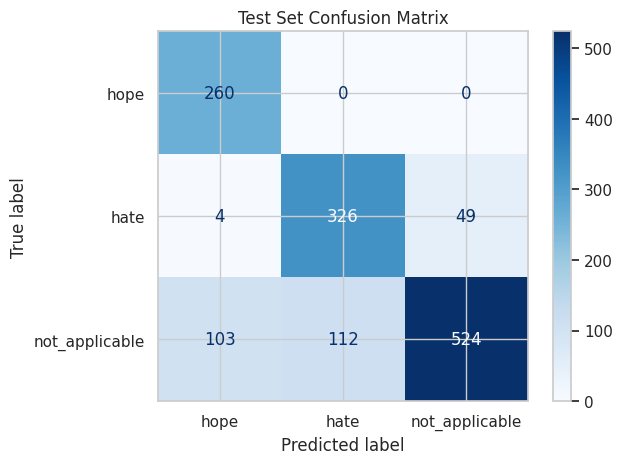

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score


# ✅ Split only for evaluation
train_texts, test_texts, train_labels, test_labels = train_test_split(
    cleaned_texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Tokenize only test set (train_loader stays same as before)
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=128)
test_dataset = ArabicDataset(test_encodings, test_labels)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#  Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

print("\n📊 Test Set Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Test Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Test Set Confusion Matrix")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Evaluation on validation.csv:
                precision    recall  f1-score   support

          hope      0.053     0.037     0.044       509
          hate      0.000     0.000     0.000       158
not_applicable      0.811     0.658     0.726       809

      accuracy                          0.373      1476
     macro avg      0.288     0.232     0.257      1476
  weighted avg      0.463     0.373     0.413      1476

🔁 Macro F1: 0.25671992370082525
🔁 Macro Accuracy: 0.37330623306233063
🔁 Macro Precision: 0.28806563275716796
🔁 Macro Recall: 0.23164335735095434


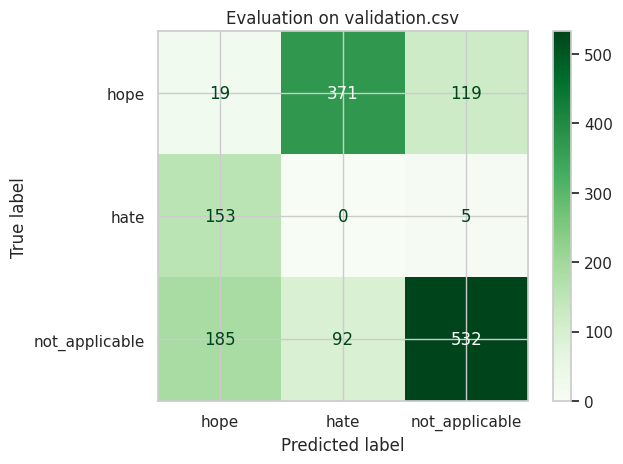

In [ ]:
## This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["predicted_label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))


#  Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#  Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new_with_undersampling.pt", map_location=device), strict=False)
model.eval()

#  Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Evaluation on validation.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on validation.csv")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Evaluation on test.csv:
                precision    recall  f1-score   support

          hope      0.043     0.038     0.040       422
          hate      0.015     0.024     0.019       287
not_applicable      0.695     0.583     0.634       768

      accuracy                          0.319      1477
     macro avg      0.251     0.215     0.231      1477
  weighted avg      0.376     0.319     0.345      1477

🔁 Macro F1: 0.23105190634239267
🔁 Macro Accuracy: 0.3188896411645227
🔁 Macro Precision: 0.2509339291344575
🔁 Macro Recall: 0.21521275639296678


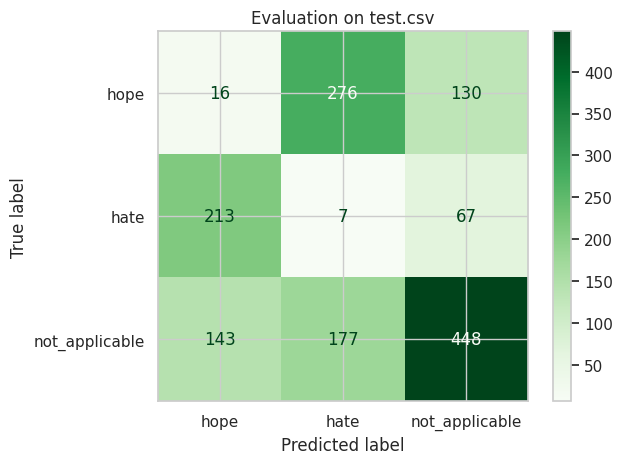

In [ ]:
## This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#  Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#  Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new_with_undersampling.pt", map_location=device), strict=False)
model.eval()

#  Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Evaluation on test.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on test.csv")
plt.show()


# With adjusted weights

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1 | Loss: 365.6264 | Accuracy: 0.5476
Epoch 2 | Loss: 276.7961 | Accuracy: 0.6652
Epoch 3 | Loss: 190.0420 | Accuracy: 0.7835
Epoch 4 | Loss: 110.4731 | Accuracy: 0.8914
Epoch 5 | Loss: 64.7340 | Accuracy: 0.9372
Epoch 6 | Loss: 47.2745 | Accuracy: 0.9575
Epoch 7 | Loss: 34.6809 | Accuracy: 0.9698
Epoch 8 | Loss: 32.1933 | Accuracy: 0.9718

📊 Classification Report:
                precision    recall  f1-score   support

          hope      0.978     0.995     0.986      1892
          hate      0.961     0.999     0.980      1301
not_applicable      0.998     0.975     0.986      3697

      accuracy                          0.985      6890
     macro avg      0.979     0.990     0.984      6890
  weighted avg      0.985     0.985     0.985      6890

🔁 Macro F1: 0.9840743862144782


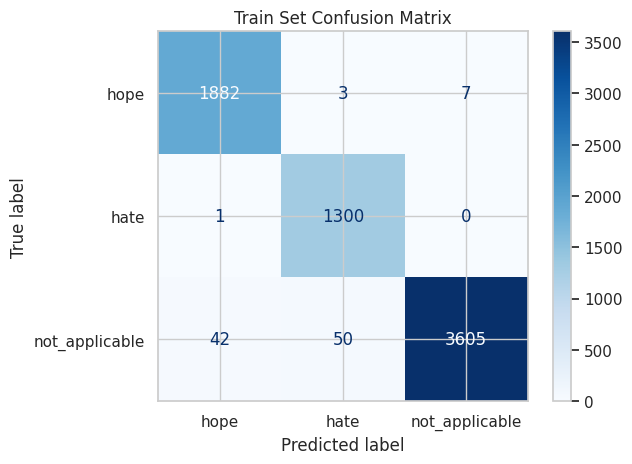

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import json, re, string, nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/train.csv")
texts_raw = df["text"].astype(str).tolist()
labels_raw = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()
labels_tensor = torch.tensor(labels_raw)

#  Compute Class Weights
class_counts = np.bincount(labels_raw)
class_weights = 1. / class_counts
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

cleaned_texts = [clean_text(t) for t in texts_raw]

#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels_raw)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

#  Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Use class weights in loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

#  Training Loop
model.train()
for epoch in range(8):
    total_loss, correct, total = 0, 0, 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels_batch).sum().item()
        total += labels_batch.size(0)

    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Accuracy: {correct/total:.4f}")

#  Evaluate on Train
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))

#  Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Train Set Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/colab_data/new models/bert_base_new_with_adjusted_weights.pt')


📊 Official Test Set Classification Report:
                precision    recall  f1-score   support

          hope      0.628     0.571     0.598       422
          hate      0.599     0.672     0.634       287
not_applicable      0.672     0.674     0.673       768

      accuracy                          0.645      1477
     macro avg      0.633     0.639     0.635      1477
  weighted avg      0.645     0.645     0.644      1477

🔁 Macro F1: 0.6350017416569596
🔁 Macro Accuracy: 0.6445497630331753
🔁 Macro Precision: 0.6329459275885959
🔁 Macro Recall: 0.6393476938852835


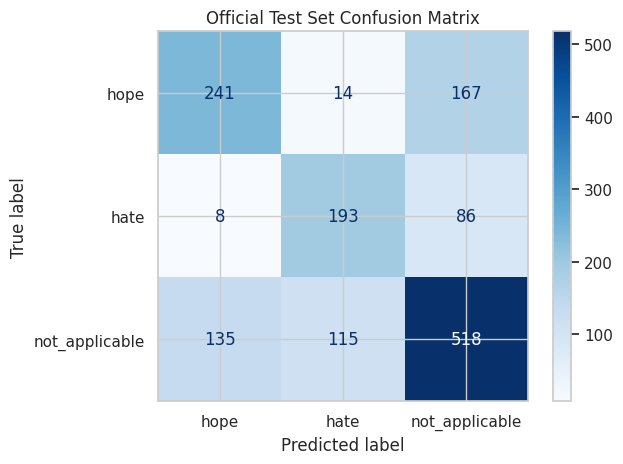

In [ ]:
#  Load official test data
df_test = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")  # official test file
texts_test = df_test["text"].astype(str).tolist()
labels_test = df_test["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Clean test texts
cleaned_texts_test = [clean_text(t) for t in texts_test]

#  Tokenize
test_encodings = tokenizer(cleaned_texts_test, padding=True, truncation=True, max_length=128)

#  Dataset & DataLoader
test_dataset = ArabicDataset(test_encodings, labels_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#  Evaluate on official test set
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

print("\n📊 Official Test Set Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Official Test Set Confusion Matrix")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Evaluation on validation.csv:
                precision    recall  f1-score   support

          hope      0.868     0.660     0.750       509
          hate      0.471     0.918     0.622       158
not_applicable      0.782     0.755     0.769       809

      accuracy                          0.740      1476
     macro avg      0.707     0.778     0.714      1476
  weighted avg      0.779     0.740     0.747      1476

🔁 Macro F1: 0.7136236852286735
🔁 Macro Accuracy: 0.7398373983739838
🔁 Macro Precision: 0.7071088735844713
🔁 Macro Recall: 0.77769759881274


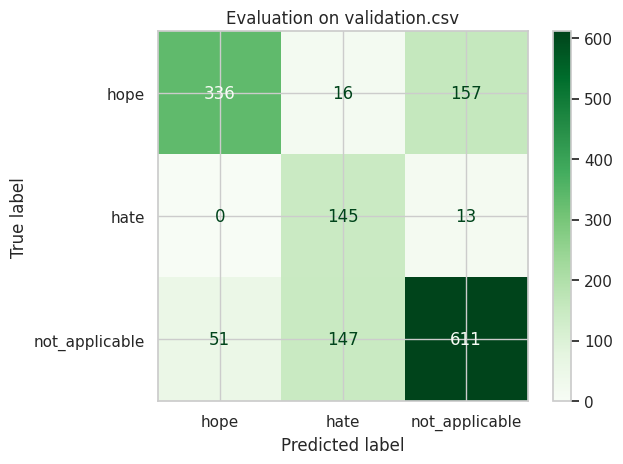

In [ ]:
## This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/validation_predictions.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["predicted_label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#  Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#  Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new_with_adjusted_weights.pt", map_location=device), strict=False)
model.eval()

#  Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Evaluation on validation.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))


cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on validation.csv")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Evaluation on test.csv:
                precision    recall  f1-score   support

          hope      0.628     0.571     0.598       422
          hate      0.599     0.672     0.634       287
not_applicable      0.672     0.674     0.673       768

      accuracy                          0.645      1477
     macro avg      0.633     0.639     0.635      1477
  weighted avg      0.645     0.645     0.644      1477

🔁 Macro F1: 0.6350017416569596
🔁 Macro Accuracy: 0.6445497630331753
🔁 Macro Precision: 0.6329459275885959
🔁 Macro Recall: 0.6393476938852835


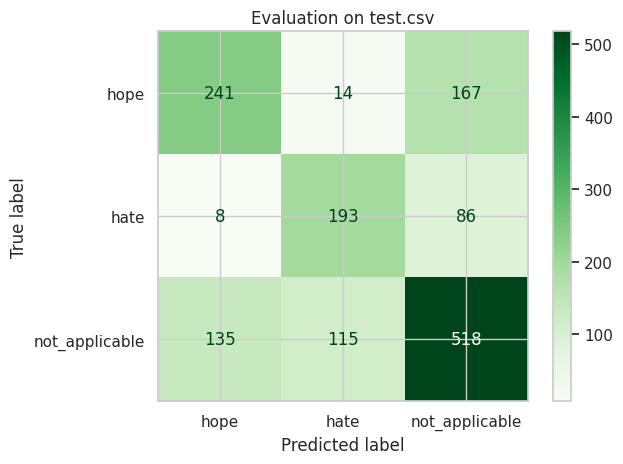

In [ ]:
## This code is just for displaying train metrics again from model

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import json, re, string, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#  Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load Data
df = pd.read_csv("/content/drive/MyDrive/colab_data/files/test.csv")
texts_raw = df["text"].astype(str).tolist()
labels = df["label"].map({"hope": 0, "hate": 1, "not_applicable": 2}).tolist()

#  Preprocessing
stopwords_arabic = set(stopwords.words('arabic'))
with open('/content/drive/MyDrive/colab_data/files/emoji_to_text.json', 'r') as f:
    emoji_to_arabic = json.load(f)
if isinstance(emoji_to_arabic, list):
    emoji_to_arabic = emoji_to_arabic[0]
emoji_pattern = re.compile("|".join(map(re.escape, emoji_to_arabic.keys())))

#  Arabic Text Cleaning Functions
def normalize_arabic(text):
    # Unify different forms of letters
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def replace_emojis_with_arabic(text):
    return emoji_pattern.sub(lambda match: emoji_to_arabic.get(match.group(0), match.group(0)), text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()



def clean_text(text):
    text = text.strip()
    text = replace_emojis_with_arabic(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_tatweel(text)
    text = remove_urls_handles(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text


cleaned_texts = [clean_text(t) for t in texts_raw]


#  Tokenization
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

#  Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
loader = DataLoader(dataset, batch_size=16)

#  Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]
        cls = self.dropout(cls)
        return self.classifier(cls)

model = BertClassifier().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/colab_data/new models/bert_base_new_with_adjusted_weights.pt", map_location=device), strict=False)
model.eval()

#  Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

#  Metrics
print("\n📊 Evaluation on test.csv:")
print(classification_report(all_labels, all_preds, target_names=["hope", "hate", "not_applicable"], digits=3))
print("🔁 Macro F1:", f1_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Accuracy:", accuracy_score(all_labels, all_preds))
print("🔁 Macro Precision:", precision_score(all_labels, all_preds, average='macro'))
print("🔁 Macro Recall:", recall_score(all_labels, all_preds, average='macro'))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["hope", "hate", "not_applicable"])
disp.plot(cmap='Greens', values_format='d')
plt.title("Evaluation on test.csv")
plt.show()
